

# Project: Investigate TMDB Movie Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected for analysis. At the end of this section, describe the questions that you plan on exploring over the course of the report. Try to build your report around the analysis of at least one dependent variable and three independent variables. If you're not sure what questions to ask, then make sure you familiarize yourself with the dataset, its variables and the dataset context for ideas of what to explore.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html


### Description of the dataset

The dataset analysed here is taken from TMDB dataset (originally taken from [this kaggle data set](https://www.kaggle.com/tmdb/tmdb-movie-metadata)). It has 10K+ entries and has multiple dependent variables such as `revenue`, `vote_count`, `vote_average` and `popularity`. Some of the fields such as `cast` are a list of strings concatenated with pipeline (`|`) character. This dataset spans movies for nearly 40 years starting since 1960.

### Things to explore

* Looking at the raw data from kaggle, we can probably try to use the revenue metric as our dependent variable as this would gauge the performance of the movie. We can keep other variables in mind such as vote average and popularity too. 
* After we decide on a dependent variable, we can choose to explore the correlation of this variable against other independent variables such as runtime, genre, cast, director(s), production studio(s) studios etc.,
* We can build concrete questions once we dive deep in to the actual dataset.

<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

### General Properties

In [2]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df_movies = pd.read_csv("tmdb-movies.csv") # Data loads.

In [3]:
# Get a snapshot of data
df_movies.head(2)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08


In [5]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

### Preliminary observations from dataset

Looking at the output of the info() call we can make the following deductions:

* Home page label is null for 75% of the movies. Overview is missing for few movies. Both these columns do not provide any insights in to our analysis and we should be able to safely drop this column.
* Imdb_id is null for 10 movies but our analysis should be unaffected by presence (or absence) 
* Production companies is also null for some of the movies. TODO
* Only 23 movies (out of 10866) are missing the genres field. 76 movies are missing the cast field. 48 movies are missing the director information. We should be able to safely drop the rows with missing genres. 
* Lot of entries are missing the keyword & production fields. It is not possible to fill the data with any trivial pandas or python functions (for e.g.: mean() does not make any sense here). However, It would not be wise to drop the rows. For what its worth, we can perform some tentative analysis for the rows that have empty keyword (or production_companies) fields with low accuracy.

In [6]:
df_movies.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


### Deeper analysis into the dataset

Now that we have a brief understanding of the dataset and its columns, we can delve deeper in to each of the features provided and plan our cleanup process.

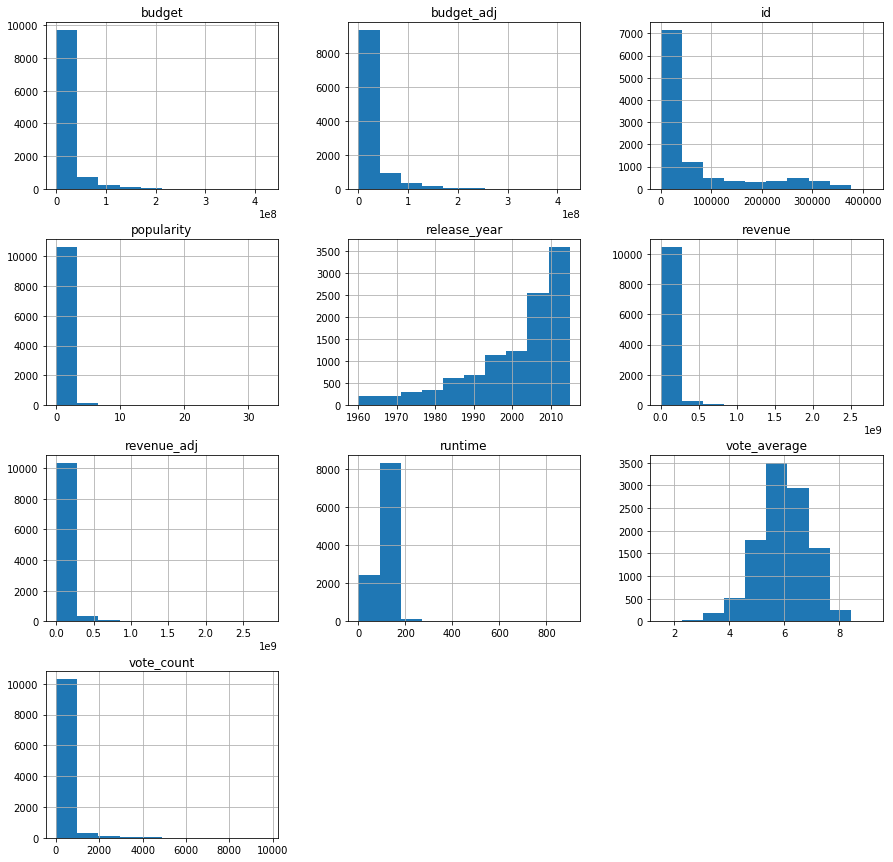

In [7]:
df_movies.hist(figsize=[15, 15]);

In [8]:
print("duplicated count : {}".format(sum(df_movies.duplicated())))

duplicated count : 1


#### Duplicated data
* Using the duplicated() method call it is evident that only one entry is duplicated and this can be dropped.

In [9]:
df_movies.describe()["popularity"]

count    10866.000000
mean         0.646441
std          1.000185
min          0.000065
25%          0.207583
50%          0.383856
75%          0.713817
max         32.985763
Name: popularity, dtype: float64

popularity < 1 : 9110
popularity > 1 : 1756
popularity > 10 : 11


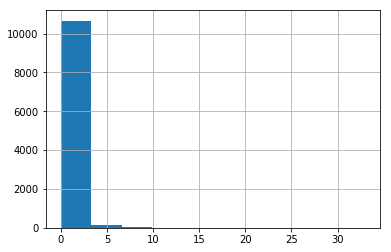

In [10]:
df_movies["popularity"].hist();
print( "popularity < 1 : {}".format(df_movies.query("popularity < 1")["popularity"].count()))
print( "popularity > 1 : {}".format(df_movies.query("popularity > 1")["popularity"].count()))
print( "popularity > 10 : {}".format(df_movies.query("popularity > 10")["popularity"].count()))

#### Errant popularity data
* Using feature based analysis we can see that there is significant discrpancy in the popularity column. Looking at the popularity statistics: 

```
mean         0.646441
std          1.000185
min          0.000065
25%          0.207583
50%          0.383856
75%          0.713817
max         32.985763
```
* Further looking at the histogram for the popularity column leads us to believe that this may be an errant data. While the max is 32, most of the movies are concentrated in the interval of 0 to 1. We can drop this column as it may not provide valuable insights. My best guess is that this errant data could have been generated by merging multiple datasets which used popularity on various scales such as 0 to 1 (could have been simplified percentile rating), 1 to 10 (like the standard IMDb rating) and 0 to 100 (as a rotten tomatoes pure percentile rating). However, this is a strong assumption to make and thus we can't use it to cleanup the popularity field. Thus it is better to just drop this column.

In [11]:
df_movies.query("release_date == ''").count()

id                      0
imdb_id                 0
popularity              0
budget                  0
revenue                 0
original_title          0
cast                    0
homepage                0
director                0
tagline                 0
keywords                0
overview                0
runtime                 0
genres                  0
production_companies    0
release_date            0
vote_count              0
vote_average            0
release_year            0
budget_adj              0
revenue_adj             0
dtype: int64

### Cleanup runtime data

There are 31 entries with zero runtime value. It may not be wise to substitute these with mean (or median) as it may affect with the accuracy of analysis process. It is better to just drop these entries as the count is quite low (< 0.01 percent).

In [12]:
print("zero budget count : {}".format(df_movies.query("budget == 0")["budget"].count()))
print("zero revenue count : {}".format(df_movies.query("revenue == 0")["revenue"].count()))

zero budget count : 5696
zero revenue count : 6016


### Surprising revelations

Looking at the output of above query and learning that half of our dataset have entries with zero revenue, we might want to reevaluate our questions. Since more than half the entries have zero as the revenue, we cannot reasonably substitue the empty values with mean (or median). Hence, we might consider the next best metric to gauge the movie's performance which is the average vote count. Let's look at the statistics for average vote count:

In [13]:
df_movies["vote_average"].describe()

count    10866.000000
mean         5.974922
std          0.935142
min          1.500000
25%          5.400000
50%          6.000000
75%          6.600000
max          9.200000
Name: vote_average, dtype: float64

Looking at above stats, the minimum value is nonzero and highest is close to 10 (this could be because it was taken on a scale of 0 - 10 as a standard imdb rating). Hence we can **consider this as the dependent variable**

In [14]:
df_movies["keywords"].head()

0    monster|dna|tyrannosaurus rex|velociraptor|island
1     future|chase|post-apocalyptic|dystopia|australia
2    based on novel|revolution|dystopia|sequel|dyst...
3                android|spaceship|jedi|space opera|3d
4                  car race|speed|revenge|suspense|car
Name: keywords, dtype: object

### Patterns to explore

Now that we decided on a depedent variable, we can explore following patterns

* Explore the correlation of `vote_average` against:
  * `genres` of the movies
  * `runtime` of the movies
  * `release_date` of the movies
  * `cast`, `production_companies`, `director` of the movies may or may not have correlation as it is harder to dedupe (E.g.: we may have multiple represenations of single entity like: Leonardo Decaprio can be represented as Leo, or Leanardo or L. Decaprio or Leo Decaprio and so on..).  
* Explore the correlation of `vote_count` against:
  * `release_date` of the movies  (movies being released in holiday seasons could have high watching rate)
* TODO : more interesting patterns

<a id='cleaning'></a>
### Data Cleaning

Now that we have explored the dataset and found multiple optimizations that can perform, let's go ahead and apply all of these cleanup operations on our dataset so that can we can make our analysis on a clean dataframe.

In [4]:
# drop the duplicate rows.
df_movies.drop_duplicates(inplace=True)

# drop non insightful columns
drop_columns = ["homepage", "overview", "popularity"]

# drop columns inplace and ignore any errors (makes it easy to rerun)
df_movies.drop(columns=drop_columns, inplace=True, errors="ignore")

# drop rows whose genres field is null
df_movies.dropna(axis=0, how="all", subset=["genres"], inplace=True)

In [5]:
# drop rows whose runtime field is null
runtime_zero = df_movies.query("runtime == 0")
df_movies.drop(index=runtime_zero.index, inplace=True, errors="ignore")
df_movies.shape

(10812, 18)

In [6]:
# Assert that there are no movies with empty genres
assert df_movies["genres"].isnull().sum() == 0

# Assert that there are no movies with zero runtime
assert df_movies.query("runtime == 0").empty

---

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Number of movies released per year

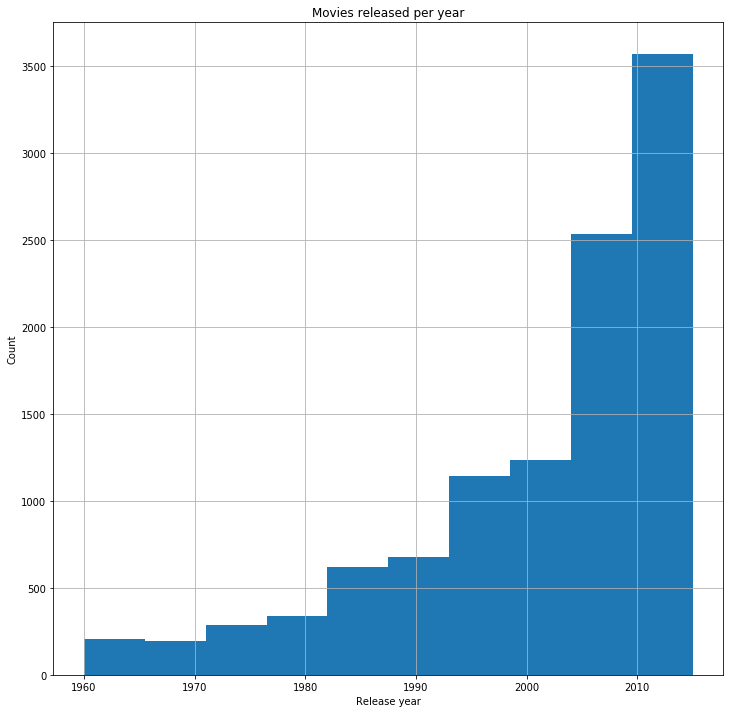

In [52]:
df_movies["release_year"].hist(figsize=[12, 12])
plt.xlabel("Release year")
plt.ylabel("Count")
plt.title("Movies released per year");

As the above graph depicts, the number of movies being released per year has consistently increased.

### Movies being released per month

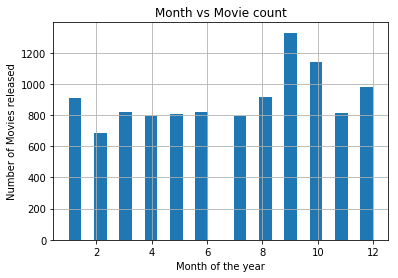

In [191]:
# Use the release_date column and split it with `/` seperator and then
# take the first value (which would be the value for month) and plot a histogram.
release_date_months = df_movies["release_date"].str.split("/", n = 2, expand=True)[0].astype(int)
release_date_months.hist(bins=24);
plt.xlabel("Month of the year")
plt.ylabel("Number of Movies released")
plt.title("Month vs Movie count");

Above graph infers that most number of movies are usually released during the second half of the year (September to January season). That being said, there are no big dips in movie release count with february being the month with least number of movies.

### Does movie release date month affect the vote average ?

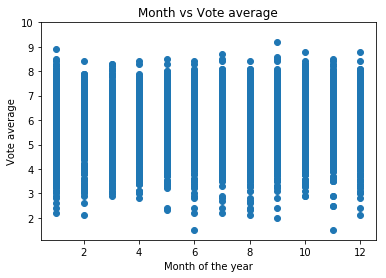

In [192]:
plt.scatter(release_date_months, df_movies.vote_average);
plt.xlabel("Month of the year")
plt.ylabel("Vote average")
plt.ylim(ymax = 10)
plt.title("Month vs Vote average");

Above graph does not infer any high confident correlation between the release date month and vote average

### Is there any relation between the vote_count and the release month of the movie ?

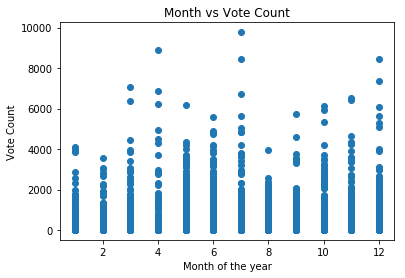

In [196]:
plt.scatter(release_date_months, df_movies.vote_count)
plt.xlabel("Month of the year")
plt.ylabel("Vote Count")
plt.title("Month vs Vote Count");

Again, there are some outliers but there isn't any pattern between the month of the movie release data and the vote count average.

In [199]:
# Define constants reused elsewhere:

column_genres = "genres"
column_vote_average = "vote_average"
column_production_companies = "production_companies"
column_cast = "cast"
column_director = "director"

# This method is used to split values in a given column with the given seperator and then return a
# value counts which would be sorted in descending order of frequency.
def get_value_counts_in_column(name: str, df: pd.DataFrame, sep: str = "|"):
    nonna_df = df.dropna(subset=[name])
    r = nonna_df[name].str.split(sep, expand=True)
    r = r.values.flatten()
    r = r[r != np.array(None)]
    return pd.value_counts(r)


#
# This method creates a dataframe by taking two columns `x` and `y` in a datafram `df`.
# 
# This is the breakdown of functionality of this method:
#  1. Split the column x with the given seperator (only `|` is used in the scope of this notebook).
#  2. Expands the column in to multiple columns based on how many values are genreated from splitting.
#  3. Stack the newly generated columns in to one (thus increasing the number of rows)
#  4. Call Groupby on the column x and only take entires with highest frequency (# of entires is controlled by count parameter)
#  5. Return a dataframe with columns as x and y.
#  
def expand_column(
    x: str, # Usually the independent variable. This column would be splitted and expanded
    y : str, # Usually the dependent variable
    df : pd.DataFrame,
    count : int = -1, # Maximum number of entries to be considered. Defaults to all
    sep: str = "|", # Seperator to split values in columns. Defaults to |
    dropna: bool = True # Drop entries whose values for x are null
):
    new_df = df.copy()
    if dropna:
        new_df.dropna(subset=[x], inplace=True)
    
    value_counts = get_value_counts_in_column(x, new_df, sep).head(count)

    expanded_df = pd.DataFrame(new_df[x].str.split(sep).tolist(), index = new_df[y]).stack()
    expanded_df = expanded_df.reset_index([0, y])
    expanded_df.columns = [y, x]
    d = expanded_df.groupby(by=x).mean()
    d = d.loc[value_counts.index.values]
    new_df = pd.DataFrame(list(zip(d.index.values, d[y].values)), columns =[x, y])
    return new_df

Explore How many movies are produced by (or in) each :
 * Genre
 * Director
 * Actor (or Actress)
 * Production Studio
 
Once we have above, we can explore the correlation of above (or say top 100 if there are too many) with vote_average

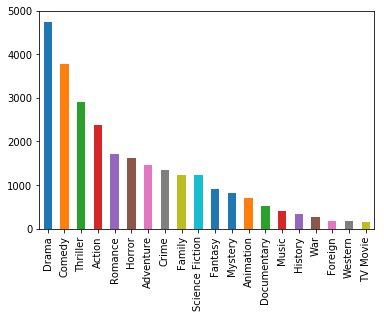

In [205]:
get_value_counts_in_column(column_genres, df_movies).plot.bar();

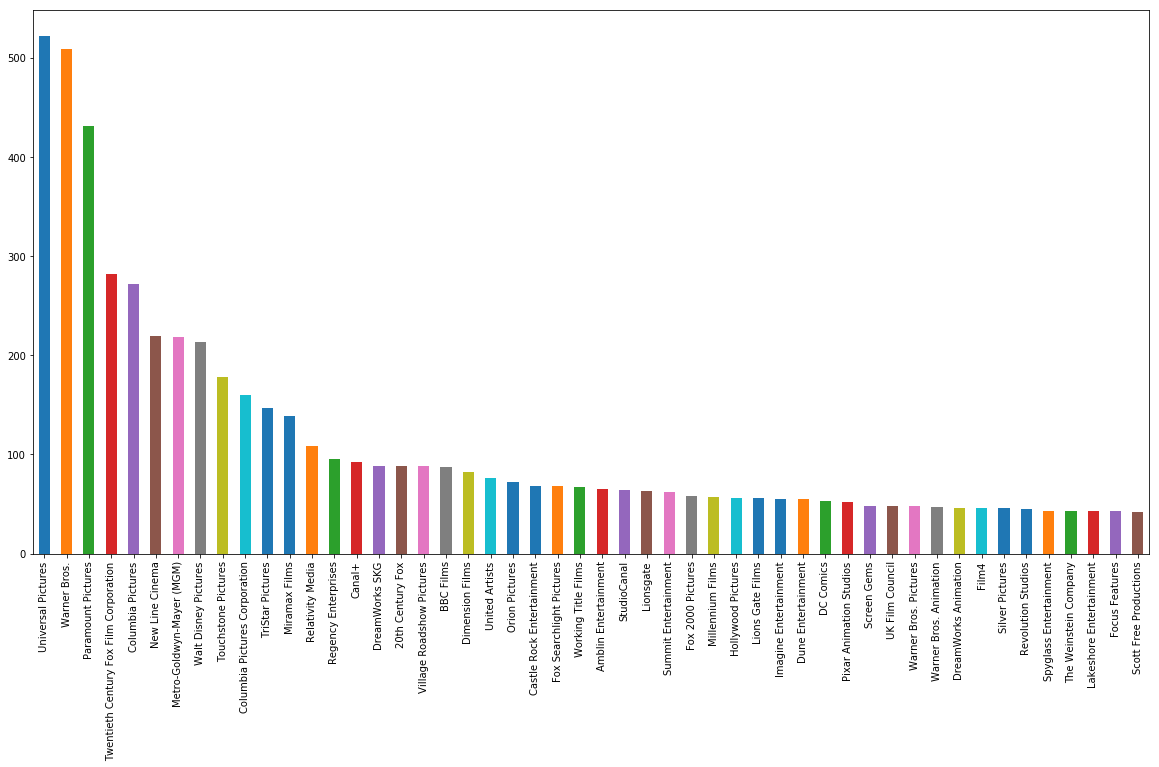

In [223]:
get_value_counts_in_column(column_production_companies, df_movies).head(50).plot.bar(figsize=[20, 10]);

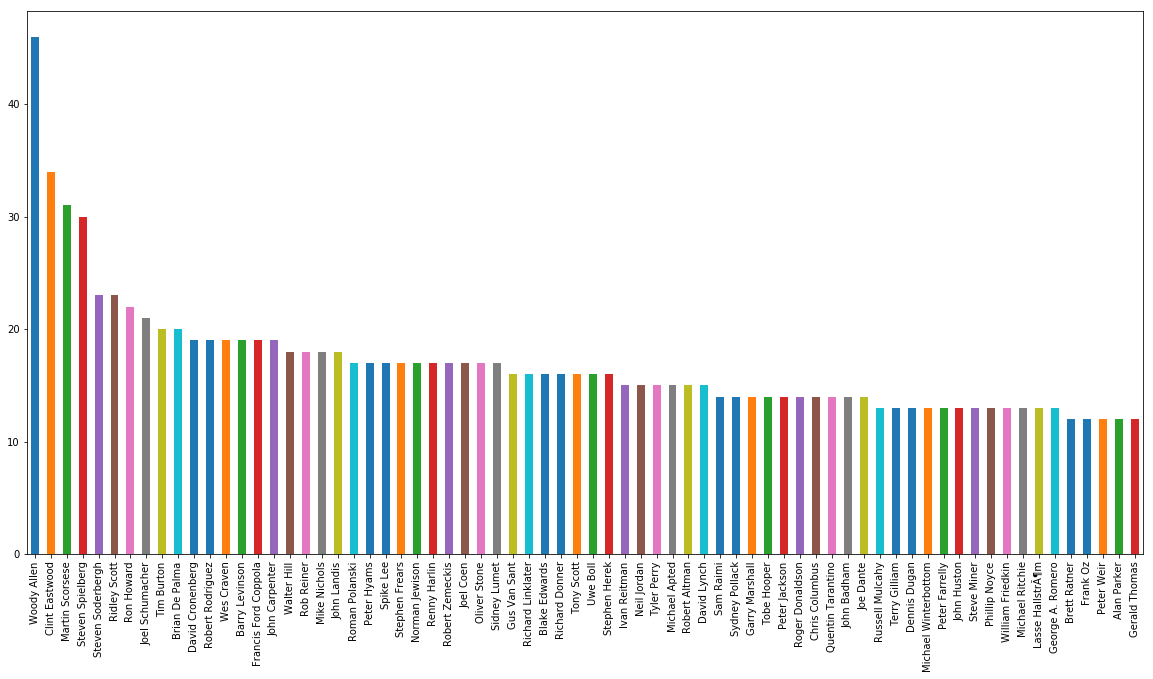

In [227]:
get_value_counts_in_column(column_director, df_movies).head(70).plot.bar(figsize=[20, 10]);

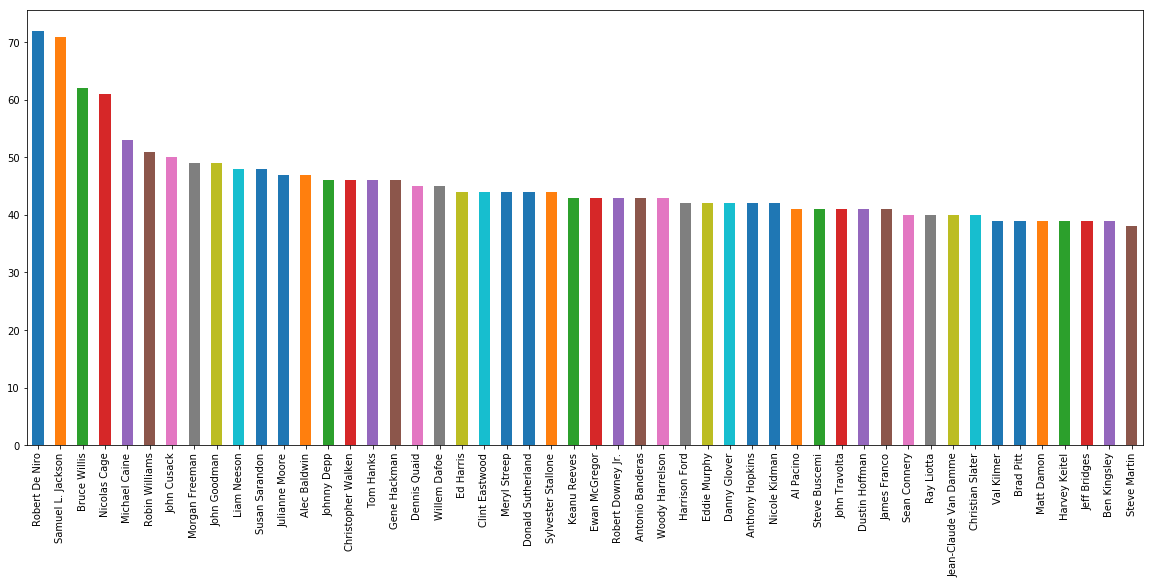

In [234]:
get_value_counts_in_column(column_cast, df_movies).head(50).plot.bar(figsize=[20, 8]);

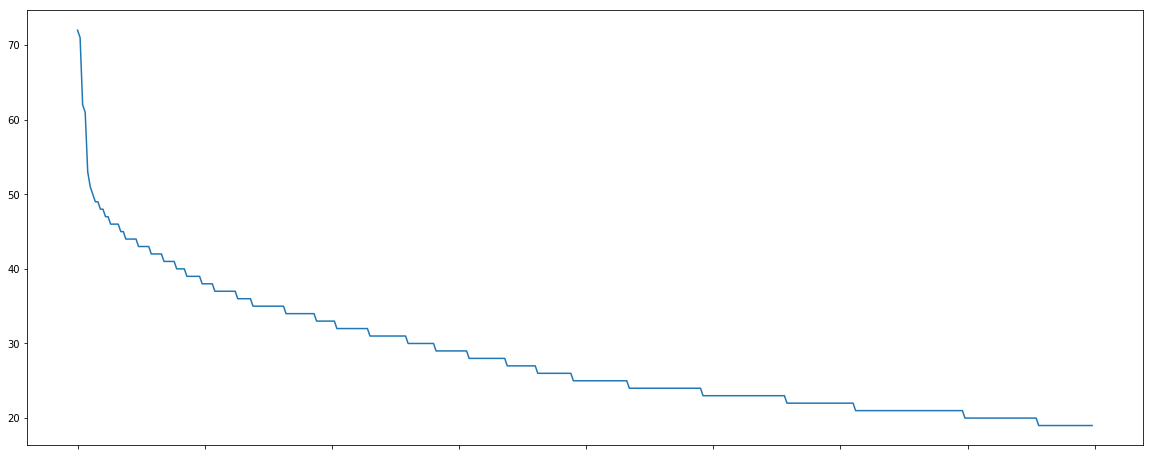

In [233]:
get_value_counts_in_column(column_cast, df_movies).head(400).plot.line(figsize=[20, 8]);

### Does vote average have any correlation with genres

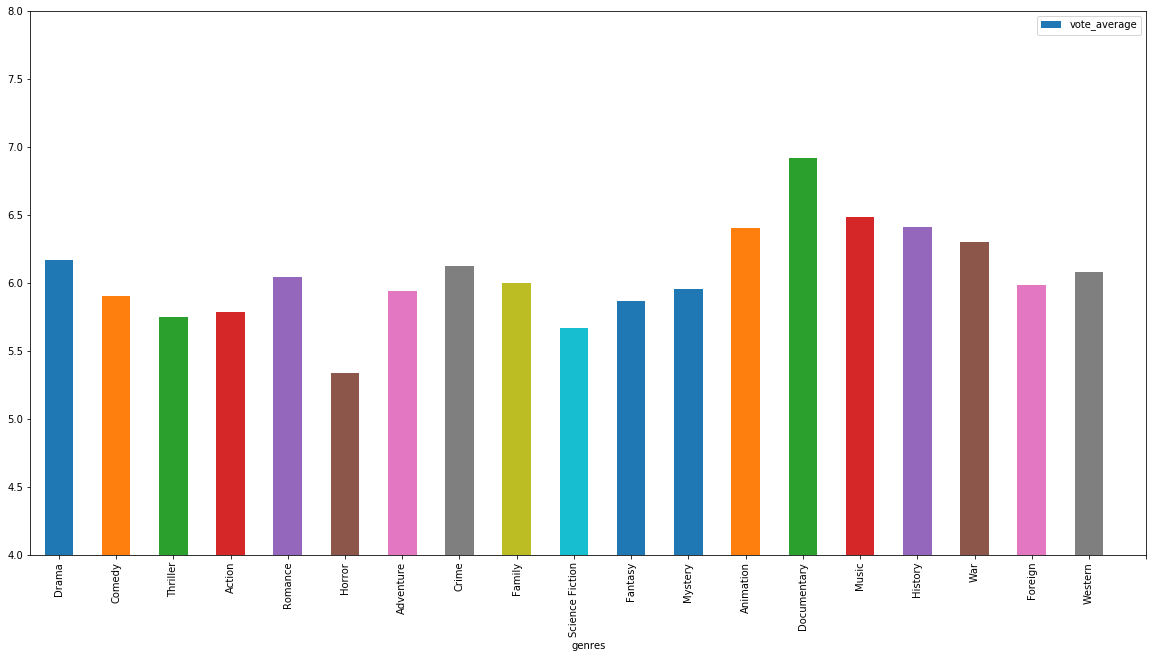

In [179]:
genres = expand_column(column_genres, column_vote_average, df_movies)
genres.plot(x = column_genres, y = column_vote_average, kind="bar", figsize=[20, 10])
plt.ylim(ymin=4, ymax=8)
plt.xticks(np.arange(20), genres[column_genres].values);

While Documentaries are usually highly rated, horror movies are poorly rated. The behavior does not change even when looking at min or max value instead of mean. There are some outliers but they still adhere to the above correlation. That being said, the affect of genre is not significant but still something that should be considered.

### Does vote average have any correlation with production companies ?

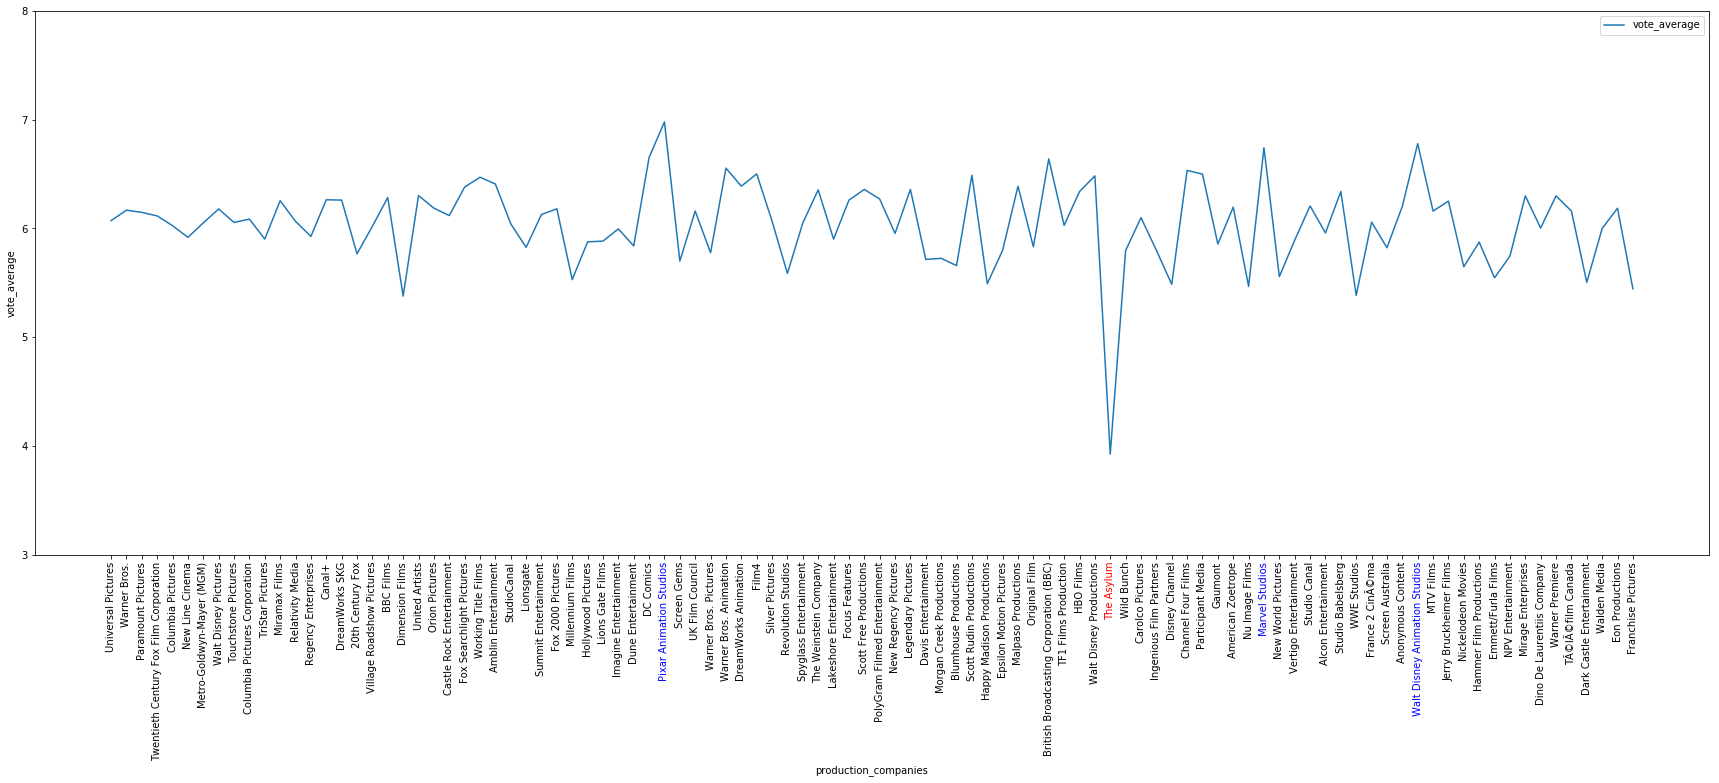

In [183]:
top_count = 100 # For this analysis consider only top 100 (by #number of movies produced) production studios.
production_companies = expand_column(column_production_companies, column_vote_average, df_movies, top_count)
production_companies.plot(x = column_production_companies, y = column_vote_average, kind="line", figsize=[30, 10])
plt.ylim(ymin=3, ymax=8)
plt.ylabel(column_vote_average)
plt.xticks(np.arange(top_count), production_companies[column_production_companies].values, rotation=90);

# highlight dips
plt.gca().get_xticklabels()[65].set_color("red")
# highlight ups
plt.gca().get_xticklabels()[36].set_color("blue")
plt.gca().get_xticklabels()[75].set_color("blue")
plt.gca().get_xticklabels()[85].set_color("blue")

Looking at above graph we can see that there are some consistent good performing studios like Pixar Animation Studios, Walt Disney Animation Studios etc.,

The Asylum seems to be the worst performer in top 100 production studios (by number of movies released). Again, there are some outliers (that can be seen when the above graph is replotted with `min()` or `max()` instead of `mean()` but those do adher to the above pattern closely. That being said, almost 40% of our dataset has null values for production_companies and this graph provides insights on only thise entries for which production studio value is present. **This is a very low confidence insight.** 

### Does vote average have any correlation with cast ?

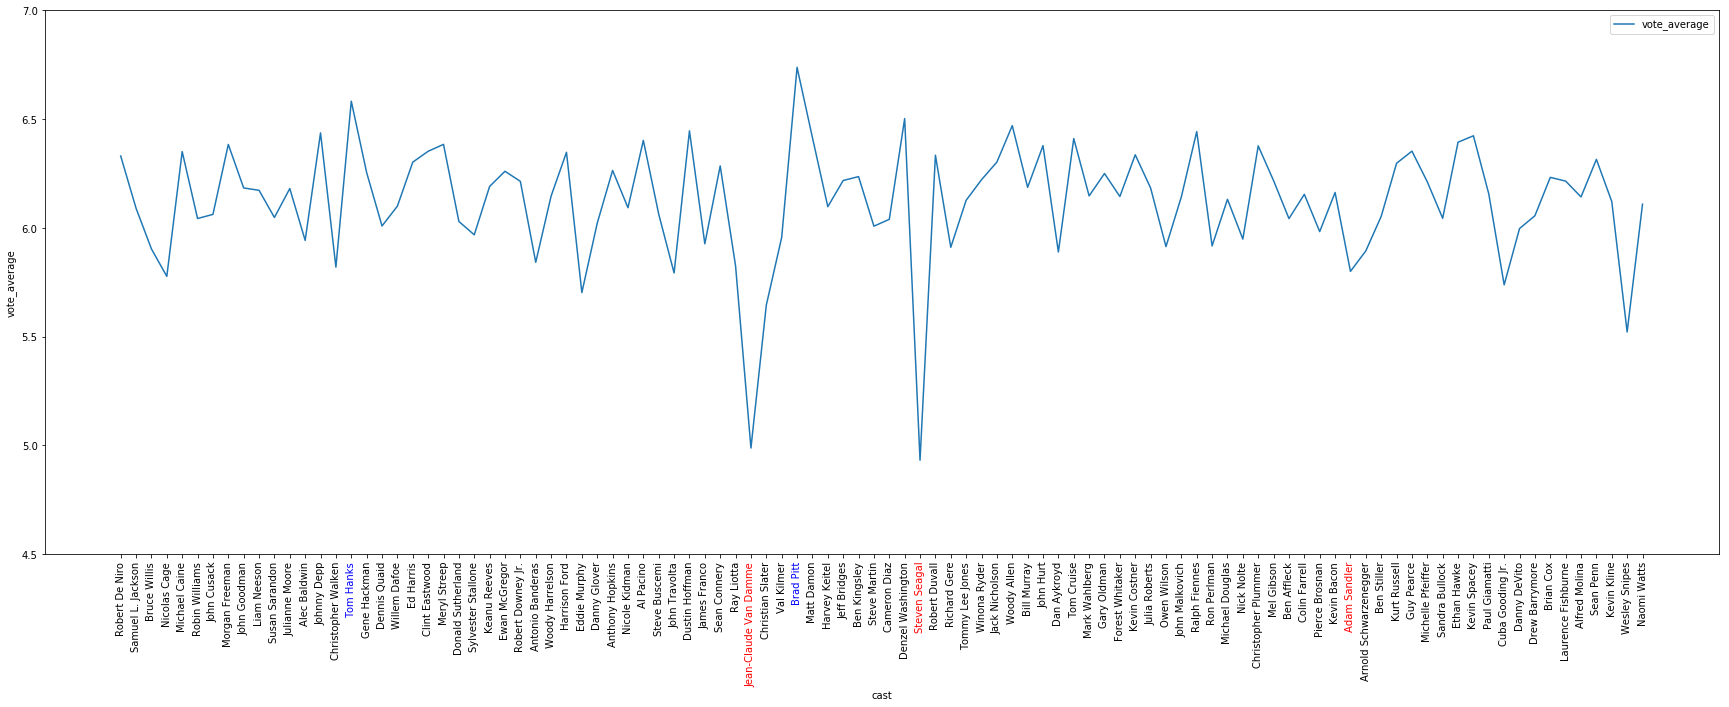

In [170]:
top_count = 100 # For this analysis consider only top 100 (by #number of movies) actors & actresses
cast = expand_column(column_cast, column_vote_average, df_movies, top_count)
cast.plot(x = column_cast, y = column_vote_average, kind="line", figsize=[30, 10])
plt.ylim(ymin=4.5, ymax=7)
plt.ylabel(column_vote_average)
plt.xticks(np.arange(top_count), cast[column_cast].values, rotation=90);

# highlight dips
plt.gca().get_xticklabels()[41].set_color("red")
plt.gca().get_xticklabels()[52].set_color("red")
plt.gca().get_xticklabels()[80].set_color("red")
# highlight ups
plt.gca().get_xticklabels()[44].set_color("blue")
plt.gca().get_xticklabels()[15].set_color("blue")

The graph shows that for top 100 cast, actors like Tom Hanks, Brad Pitt and Denzel Washington seem to bring in good ratings for the movie while actors like Jean-Claude Van Dammme and Steven Seagal seem to perfom poorly.

When the above graph is replotted with `max()` instead of `mean()` same pattern is observed. If it is plotted with `min()` values, then Adam Sandler seems to have perfomed poorly (we can see a serious dip for Adam sandler in above graph as well but it becomes significant if plotted with min values)

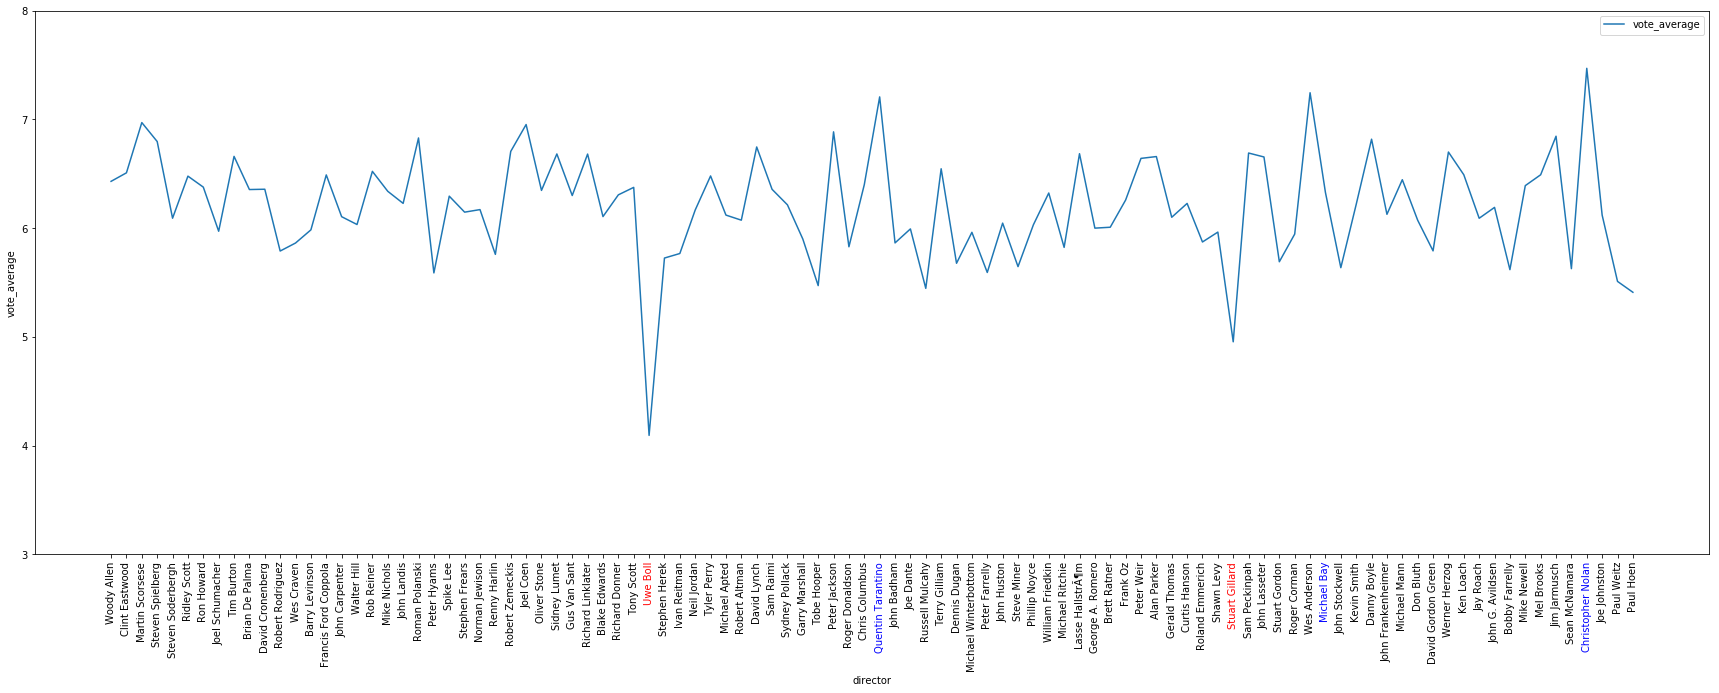

In [189]:
top_count = 100 # For this analysis consider only top 100 (by #number of movies) directors
director = expand_column(column_director, column_vote_average, df_movies, top_count)
director.plot(x = column_director, y = column_vote_average, kind="line", figsize=[30, 10])
plt.ylim(ymin=3, ymax=8)
plt.ylabel(column_vote_average)
plt.xticks(np.arange(top_count), director[column_director].values, rotation=90);

# highlight dips
plt.gca().get_xticklabels()[35].set_color("red")
plt.gca().get_xticklabels()[73].set_color("red")
# highlight ups
plt.gca().get_xticklabels()[50].set_color("blue")
plt.gca().get_xticklabels()[79].set_color("blue")
plt.gca().get_xticklabels()[96].set_color("blue")

While there are some directors who do consistently well with vote average there are some who do poorly. But as a overall theme most of the directors lie in the average range of 5.5 to 7

### How does vote_average vary w.r.t runtime

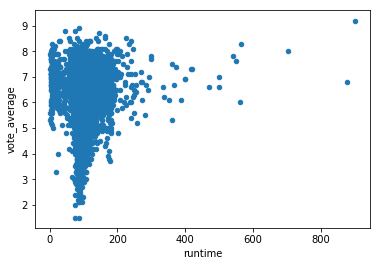

In [249]:
df_movies.plot(x="runtime", y="vote_average", kind="scatter");

There is a highly even distribution of movie runtimes between 0 and 200 minutes. Most of the movies lie in this range with few outliers execeeding 200 range and even fewer exceeding 400 minute range. Longer movies (> 400) almost always perform higher in vote_average. This could be probably because most of these are documentaries. That being said runtime does not provide any strong correlation with vote average except for the thought that very long movies recevie good ratings.

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])